In [7]:
import json
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from glob import glob
import matplotlib.colors as mcolors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
np.set_printoptions(formatter={'float': lambda x: " | {0:0.2f}".format(x)})

In [ ]:

"""
msg_1 - message sent by agent 1
msg_2 - "                   " 2
probs_1 - the underlying probability vector for every bit in message 1
probs_2 - the underlying probability vector for every bit in message 2

msg_1_ent - entropy of message 1 (calculated on probs_1)
msg_2_ent - entropy of message 2 (calculated on probs_2)

non_blank_partition - 
  1 = partition 1 is non blank
  2 = partition 2 is non blank
  0 = both partitions are non blank

p - part of the image that agent1 sees (for agent2 it is 1-p)

caption - correct caption
shape - one of ['circle', 'cross', 'ellipse', 'pentagon', 'rectangle', 'semicircle', 'square', 'triangle']
color - one of ['blue', 'cyan', 'gray', 'green', 'magenta', 'red', 'yellow']

texts - all 10 descriptions
texts_shapes - shape for all 10 descs
texts_color - colors "              "

correct - was the trial succeful (both players guessing right)
"""

In [8]:
shapes = ['circle', 'cross', 'ellipse', 'pentagon', 'rectangle', 'semicircle', 'square', 'triangle']
colors = ['blue', 'cyan', 'gray', 'green', 'magenta', 'red', 'yellow']

df = pd.DataFrame()
for p in glob("../languages/pretrained_10_1*"):
  with open(p) as f:
      task_data = json.load(f)
  df = df.append(pd.DataFrame(task_data))

In [ ]:
all_msg = np.array(df.msg_1.append(df.msg_2).tolist()).squeeze()
all_msg.shape

(18000, 8)

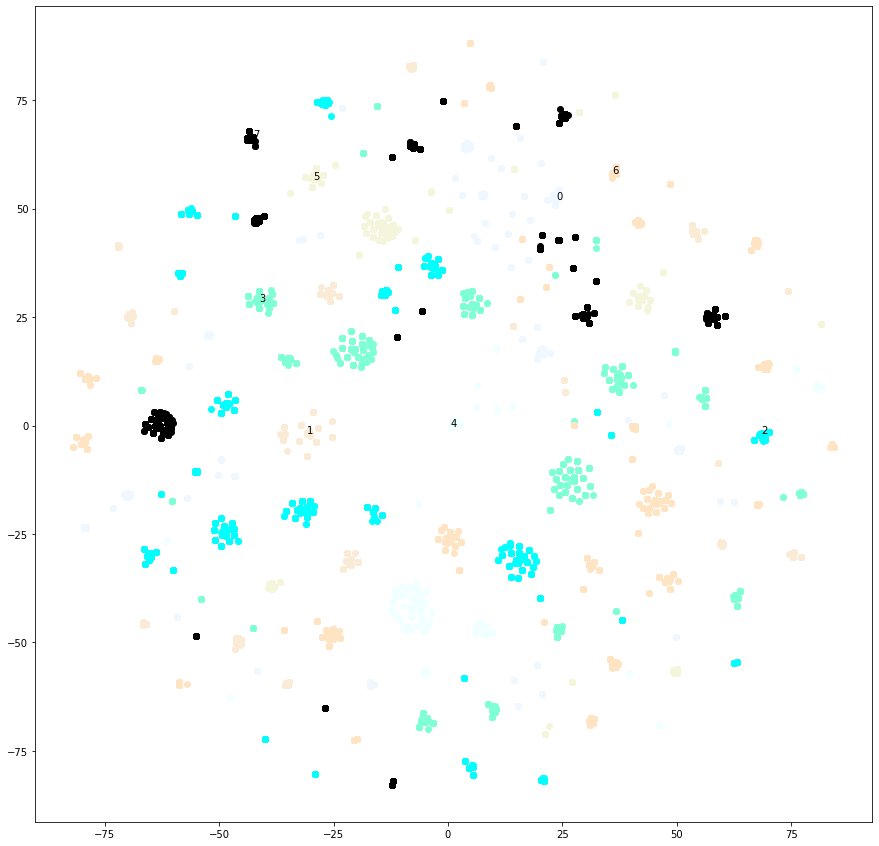

In [ ]:
k = 8
km = KMeans(k)
res = km.fit_predict(all_msg)
tsne = TSNE(2)
tsne_msg = tsne.fit_transform(all_msg)

plt.figure(figsize=(15,15))
for i, c in zip(range(k), mcolors.cnames):
  d = tsne_msg[res==i]
  plt.scatter(d[:, 0], d[:,1], label=i, color=c)
  plt.annotate(str(i), d[0])

In [ ]:
df1 = df[(df.non_blank_partition.isin([0,1])) & (df.correct)][['msg_1', 'probs_1', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_1':'msg', 'probs_1':'prob'})
df2 = df[(df.non_blank_partition.isin([0,2])) & (df.correct)][['msg_2', 'probs_2', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_2':'msg', 'probs_2':'prob'})
df2.p = 1-df2.p
msg_df = pd.concat([df1, df2])

df1 = df[df.non_blank_partition.isin([2])][['msg_1', 'probs_1', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_1':'msg', 'probs_1':'prob'})
df2 = df[df.non_blank_partition.isin([1])][['msg_2', 'probs_2', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_2':'msg', 'probs_2':'prob'})
df2.p = 1-df2.p
blank_msg_df = pd.concat([df1, df2])

In [ ]:
all_msg = np.array(msg_df.msg.tolist()).squeeze()
all_prob = np.array(msg_df.prob.tolist()).squeeze()
tsne_msg = TSNE(2).fit_transform(all_msg)

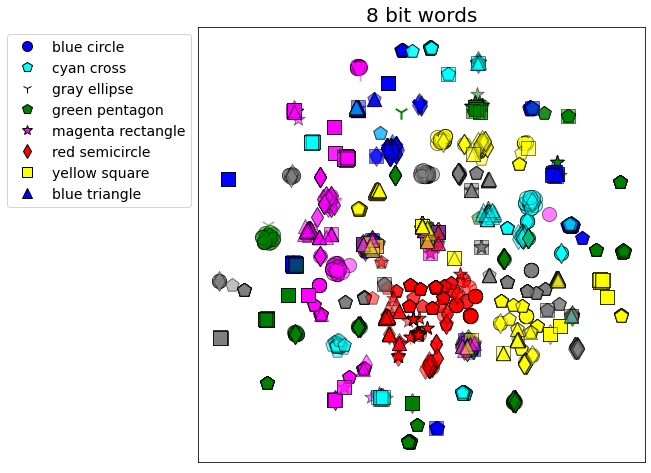

In [ ]:
shapes = ['circle', 'cross', 'ellipse', 'pentagon', 'rectangle', 'semicircle', 'square', 'triangle']
shapes_ = ['o',       'p',      "1",        "p",        "*",          "d",        "s",      "^"]
colors = ['blue', 'cyan', 'gray', 'green', 'magenta', 'red', 'yellow']

import matplotlib.lines as mlines
legend = []
for c, s, s_name in zip(['blue', 'cyan', 'gray', 'green', 'magenta', 'red', 'yellow', 'blue'],
                shapes_,
                shapes):
  legend.append(mlines.Line2D([], [], color=c, marker=s, linestyle='None',
                          markersize=10, label=f'{c} {s_name}', markeredgecolor='k'))

plt.figure(figsize=(8,8))
for s, s_ in zip(shapes, shapes_):
  for c in colors:
    d = tsne_msg[(msg_df["shape"]==s) & (msg_df["color"]==c)]
    plt.scatter(d[:, 0], d[:,1], label=f"{c} {s}", color=c, marker=s_, edgecolors="k", s=200, alpha=0.5)
plt.legend(handles=legend, bbox_to_anchor=(0, 1), fontsize=14)
plt.xticks([])
plt.yticks([])
plt.title("8 bit words", fontdict={'fontsize':20})
plt.show()

,circle,cross,ellipse,pentagon,rectangle,semicircle,square,triangle
f1_comp,0.753894,0.886486,0.544803,0.829268,0.664879,0.761905,0.455446,0.871622
recall_comp,0.679775,0.800000,0.395833,0.735135,0.708571,0.782222,0.815603,0.777108
precision_comp,0.846154,0.993939,0.873563,0.951049,0.626263,0.742616,0.315934,0.992308
f1_not_comp,0.759259,0.886486,0.553333,0.826748,0.600000,0.601881,0.760784,0.859060
recall_not_comp,0.691011,0.800000,0.432292,0.735135,0.720000,0.853333,0.687943,0.771084
precision_not_comp,0.842466,0.993939,0.768519,0.944444,0.514286,0.464891,0.850877,0.969697



comp feature importances [ | 0.00  | 0.00  | 0.00  | 0.27  | 0.00  | 0.18  | 0.37  | 0.18]

not comp feature importances [ | 0.05  | 0.02  | 0.03  | 0.24  | 0.02  | 0.16  | 0.32  | 0.16]

average f1 comp 0.7210378765248769
average f1 not comp 0.7309440491996027


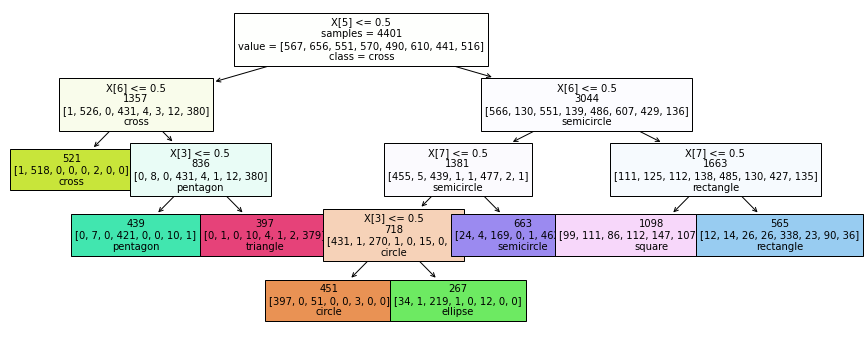

In [ ]:
df_ = msg_df.dropna(axis=0, subset=["shape"])
# df_ = msg_df.fillna('None')
y = df_["shape"]
X = np.array(df_.msg.tolist()).squeeze()
X_t, X_te, y_t, y_te = train_test_split(X[:, :], y, test_size=0.25)

tree = DecisionTreeClassifier(max_leaf_nodes=8)
tree.fit(X_t, y_t)
y_ = tree.predict(X_te)

tree_no_limit = DecisionTreeClassifier()
tree_no_limit.fit(X_t, y_t)
y_no_limit = tree_no_limit.predict(X_te)

res = pd.DataFrame(np.vstack([f1_score(y_te, y_, average=None),
                              recall_score(y_te, y_, average=None),
                              precision_score(y_te, y_, average=None),
                              
                              f1_score(y_te, y_no_limit, average=None),
                              recall_score(y_te, y_no_limit, average=None),
                              precision_score(y_te, y_no_limit, average=None)]),
                    index=["f1_comp", "recall_comp", "precision_comp", "f1_not_comp", "recall_not_comp", "precision_not_comp"], columns=tree.classes_)
display(res)
print(f"\ncomp feature importances", tree.feature_importances_)
print(f"\nnot comp feature importances", tree_no_limit.feature_importances_)

print("\naverage f1 comp", res.loc['f1_comp'].mean())
print("average f1 not comp", res.loc['f1_not_comp'].mean())

plt.figure(figsize=(15,6))
plt.title("comp tree")
plot_tree(tree, fontsize=10, filled=True, class_names=tree.classes_, impurity=False, label='root', precision=2)
plt.show()

,blue,cyan,gray,green,magenta,red,yellow
f1_comp,0.887671,0.869976,0.683938,0.899767,0.902935,0.885496,0.898072
recall_comp,0.810000,0.776371,0.996226,0.828326,0.826446,0.798165,0.819095
precision_comp,0.981818,0.989247,0.520710,0.984694,0.995025,0.994286,0.993902
f1_not_comp,0.887671,0.869976,0.683938,0.899767,0.902935,0.885496,0.898072
recall_not_comp,0.810000,0.776371,0.996226,0.828326,0.826446,0.798165,0.819095
precision_not_comp,0.981818,0.989247,0.520710,0.984694,0.995025,0.994286,0.993902



comp feature importances [ | 0.50  | 0.17  | 0.17  | 0.00  | 0.17  | 0.00  | 0.00  | 0.00]
not comp feature importances [ | 0.46  | 0.15  | 0.17  | 0.00  | 0.15  | 0.02  | 0.04  | 0.00]

average f1 comp 0.8611220945160544
average f1 not comp 0.8611220945160544


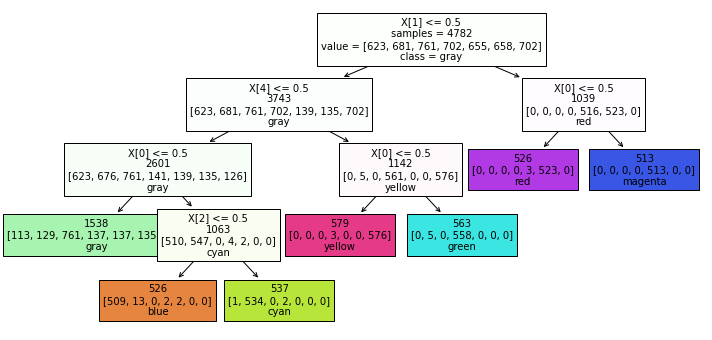

In [ ]:
df_ = msg_df.dropna(axis=0, subset=["color"])
y = df_["color"]
X = np.array(df_.msg.tolist()).squeeze()
X_t, X_te, y_t, y_te = train_test_split(X[:, :], y, test_size=0.25)

tree = DecisionTreeClassifier(max_leaf_nodes=7)
tree.fit(X_t, y_t)
y_ = tree.predict(X_te)

tree_no_limit = DecisionTreeClassifier()
tree_no_limit.fit(X_t, y_t)
y_no_limit = tree_no_limit.predict(X_te)

res = pd.DataFrame(np.vstack([f1_score(y_te, y_, average=None),
                              recall_score(y_te, y_, average=None),
                              precision_score(y_te, y_, average=None),
                              
                              f1_score(y_te, y_no_limit, average=None),
                              recall_score(y_te, y_no_limit, average=None),
                              precision_score(y_te, y_no_limit, average=None)]),
                    index=["f1_comp", "recall_comp", "precision_comp", "f1_not_comp", "recall_not_comp", "precision_not_comp"], columns=tree.classes_)
display(res)
print(f"\ncomp feature importances", tree.feature_importances_)
print(f"not comp feature importances", tree_no_limit.feature_importances_)

print("\naverage f1 comp", res.loc['f1_comp'].mean())
print("average f1 not comp", res.loc['f1_not_comp'].mean())

plt.figure(figsize=(12,6))
plt.title("comp tree")
plot_tree(tree, fontsize=10, filled=True, class_names=tree.classes_, impurity=False, label='root', precision=2 )
plt.show()

# predict other labels

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
blank_msg_df["blank"] = True
msg_df['blank'] = False
df_ = pd.concat([blank_msg_df, msg_df]).sample(frac=1)
y = df_["blank"]
X = np.array(df_.msg.tolist()).squeeze()
X_t, X_te, y_t, y_te = train_test_split(X[:, :], y, test_size=0.25)
tree = DecisionTreeClassifier()
tree.fit(X_t, y_t)
y_ = tree.predict(X_te)
y_p = tree.predict_proba(X_te)[:,1]
res = pd.DataFrame(np.vstack([f1_score(y_te, y_, average=None),
                              recall_score(y_te, y_, average=None),
                              precision_score(y_te, y_, average=None)]),
                    index=["f1", "recall", "precision"], columns=tree.classes_)
display(res)
print("auc score", roc_auc_score(y_te, y_p))
print(f"prior:{y.mean():.3f}")
print(f"\nfeature importances", tree.feature_importances_)
# plt.figure(figsize=(30,10))
# plot_tree(tree, fontsize=10, filled=True, label='root', precision=2)
# plt.show()

,False,True
f1,0.588262,0.432483
recall,0.656093,0.378540
precision,0.533142,0.504354


auc score 0.5334698554368597
prior:0.488

feature importances [ | 0.10  | 0.14  | 0.16  | 0.18  | 0.13  | 0.11  | 0.11  | 0.08]


In [ ]:
df1_ = df[(df.non_blank_partition.isin([0,1]))][['msg_1', 'probs_1', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_1':'msg', 'probs_1':'prob'})
df2_ = df[(df.non_blank_partition.isin([0,2]))][['msg_2', 'probs_2', 'p', 'shape', 'color', 'correct']].rename(columns={'msg_2':'msg', 'probs_2':'prob'})
df2_.p = 1-df2_.p
msg_df_ = pd.concat([df1_, df2_])

In [ ]:
blank_msg_df["blank"] = True
msg_df_['blank'] = False
df_ = pd.concat([blank_msg_df, msg_df_]).sample(frac=1)
y = df_["correct"]
X = np.array(df_.msg.tolist()).squeeze()
X_t, X_te, y_t, y_te = train_test_split(X[:, :], y, test_size=0.25)
tree = DecisionTreeClassifier()
tree.fit(X_t, y_t)
y_ = tree.predict(X_te)
y_p = tree.predict_proba(X_te)[:,1]

res = pd.DataFrame(np.vstack([f1_score(y_te, y_, average=None),
                              recall_score(y_te, y_, average=None),
                              precision_score(y_te, y_, average=None)]),
                    index=["f1", "recall", "precision"], columns=tree.classes_)
display(res)
print("auc score", roc_auc_score(y_te, y_p))
print(f"prior:{y.mean():.3f}")
print(f"\nfeature importances", tree.feature_importances_)

,False,True
f1,0.029617,0.858125
recall,0.015219,0.995862
precision,0.548387,0.753860


auc score 0.6049781267176368
prior:0.756

feature importances [ | 0.24  | 0.08  | 0.07  | 0.07  | 0.10  | 0.08  | 0.25  | 0.10]
